In [62]:
%reload_ext autoreload
%autoreload 2

import numpy as np

import warnings
import torch
import pickle
import matplotlib.pyplot as plt

from Probe import get_pdata, probe_shapelet
import utils
from utils.constants import xai_names
from utils.visualization import plot_multiple_images_with_attribution
from utils.shapelet import get_distances_info_gain
from utils.model_utils import get_gradient_from_layers
from utils.insert_shapelet import get_gt_attr
warnings.filterwarnings("ignore")

In [63]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [64]:
from tsai.models.FCN import FCN

model_path = 'models/simu2/'
model = FCN(c_in=1, c_out=2)
state_dict = torch.load(f'{model_path}/weight.pt',map_location='cuda:1')
model.load_state_dict(state_dict)
model.eval()

with open(f'models/simu2/data.pkl', 'rb') as f:
    data = pickle.load(f)
data.keys()
train_x, test_x, train_y, test_y = data['train_x'], data['test_x'], data['train_y'], data['test_y']
test_preds = np.load('models/simu2/test_preds.npy')
test_y = np.argmax(test_y, axis=1)
train_y = np.argmax(train_y, axis=1)

# instance_length = train_x.shape[-1]

# with open(f'shapelets/GunPoint/RSTF.pkl', 'rb') as f:
#     ST_attribution = pickle.load(f)
# # pick the first Shapelet
# info_gain, shapelet_length, start_pos, dimension, inst_index, shapelet_class, z_norm_shapelet = ST_attribution.shapelets[0]

In [65]:
model.to(device)
train_x_pred = model(torch.from_numpy(train_x).float().to(device)).detach().cpu().numpy()

In [66]:
zero_input = np.zeros((100,1,1000)) 
zero_input = zero_input + np.random.normal(0, 0.01, zero_input.shape)
zero_pred = model(torch.from_numpy(zero_input).float().to(device)).detach().cpu().numpy()


In [67]:
train_x_pred.shape

(1000, 2)

DeepLift


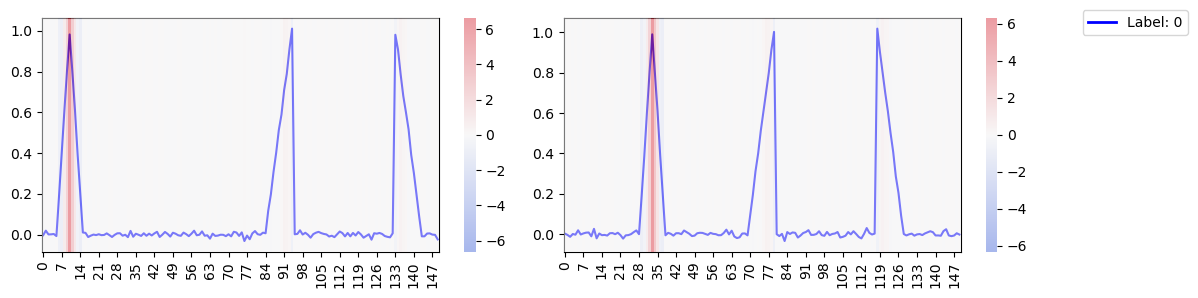

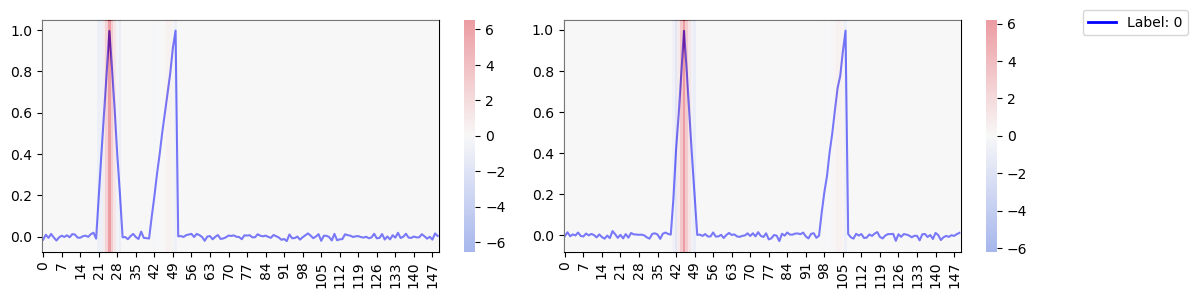

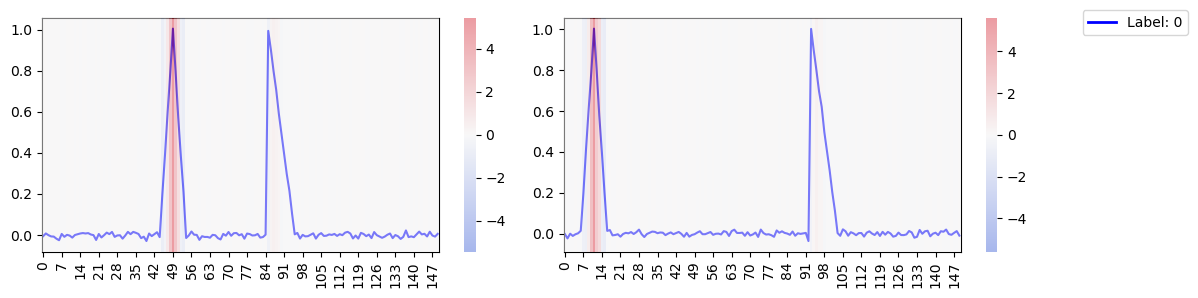

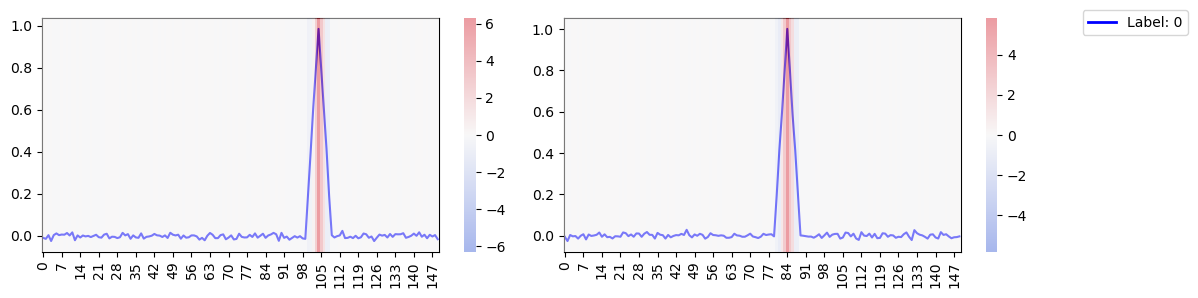

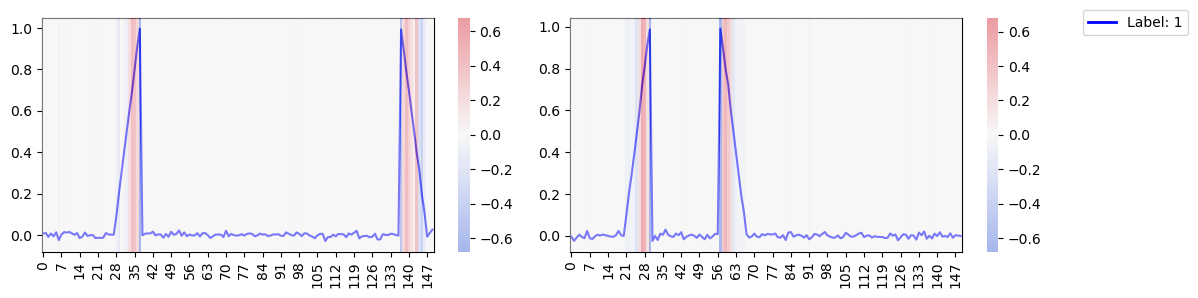

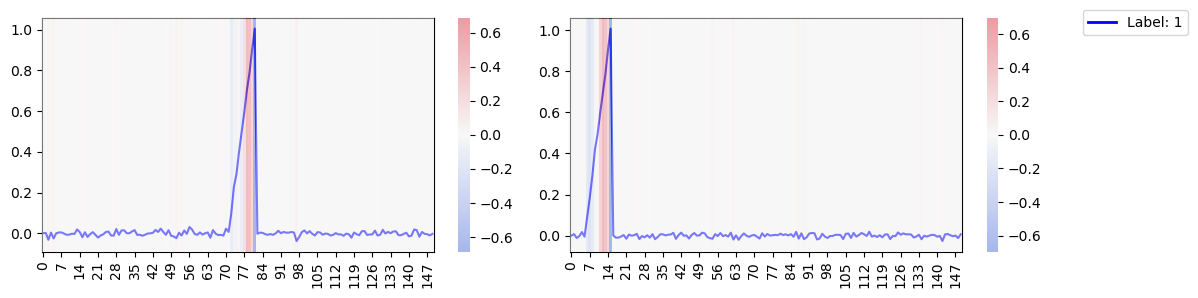

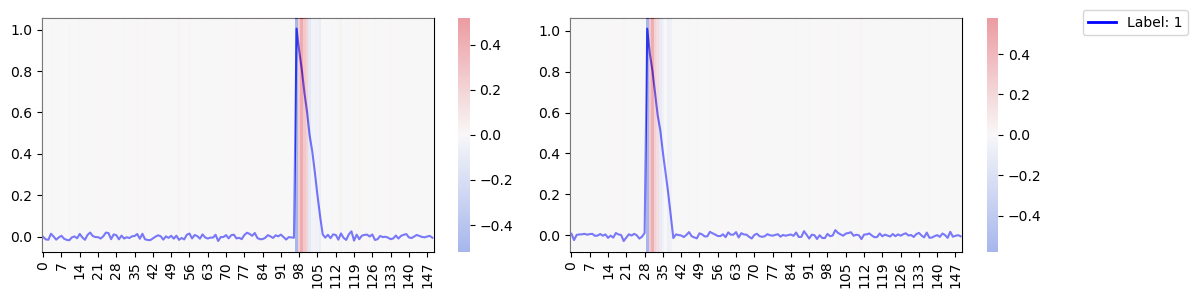

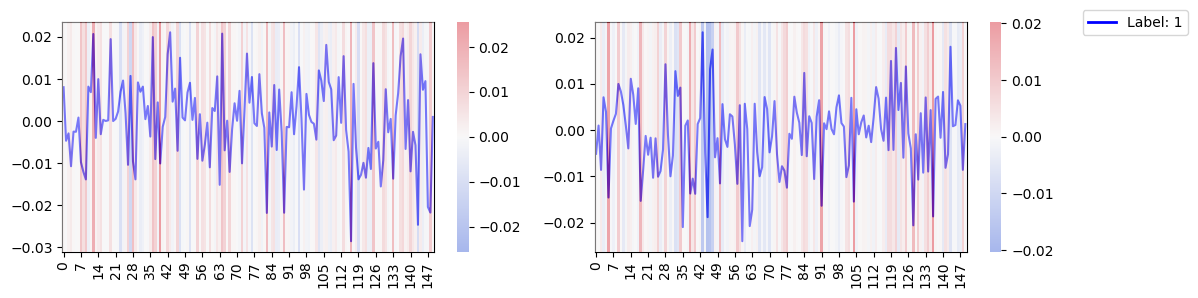

In [69]:
for xai_name in ['DeepLift']:
    print(xai_name)
    attr_gp, _= get_gt_attr(model,train_x,None,None,
                            save_dir=f'attributions/simu2/{xai_name}/exp.pkl',
                            xai_name=xai_name,target_class=0)


    with open(f'attributions/simu2/{xai_name}/exp.pkl', 'rb') as f:
        attr = pickle.load(f)
    attr_gp = attr['attributions']
    for i in range(8):
        plot_multiple_images_with_attribution(train_x[0+i*125:125+i*125], train_y[0+i*125:125+i*125], 2,figsize=(12,3), 
                                      use_attribution=True,
                                      attributions=attr_gp[0+i*125:125+i*125],
                                      normalize_attribution=True,
                                      save_path=None,
                                      test_y = train_y[0+i*125:125+i*125],
                                     )
    

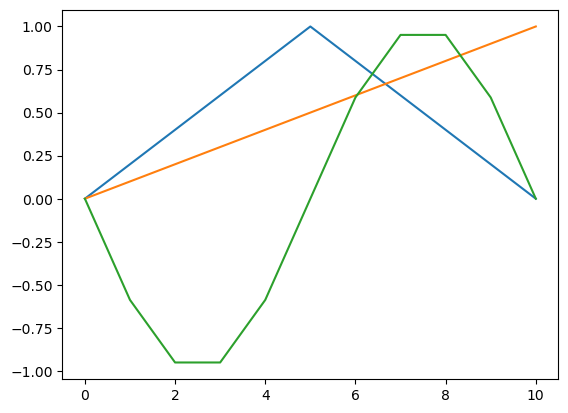

In [93]:
s1 =  np.concatenate((np.arange(-0.5,0.5,0.2),np.arange(0.5,-0.6,-0.2)))+0.5
s5 = np.arange(-0.5,0.6,0.1)+0.5

seen_feature = s1
plt.plot(seen_feature)

seen_nonfeature = s5
plt.plot(seen_nonfeature)

unseen_nonfeature = np.sin(np.linspace(-np.pi,np.pi,11))
plt.plot(unseen_nonfeature)

instance_length = train_x.shape[-1]

dealing with ECG200: (100, 1, 96)
dealing with Beef: (30, 1, 470)
dealing with ElectricDevices: (8926, 1, 96)
dealing with Earthquakes: (322, 1, 512)
dealing with Wafer: (1000, 1, 152)
dealing with PowerCons: (180, 1, 144)
dealing with NonInvasiveFetalECGThorax1: (1800, 1, 750)
dealing with ECG5000: (500, 1, 140)
dealing with HandOutlines: (1000, 1, 2709)
dealing with CBF: (30, 1, 128)
dealing with FordA: (3601, 1, 500)
dealing with TwoPatterns: (1000, 1, 128)
dealing with UWaveGestureLibraryAll: (896, 1, 945)
dealing with Chinatown: (20, 1, 24)
dealing with Yoga: (300, 1, 426)
dealing with DistalPhalanxOutlineCorrect: (600, 1, 80)
dealing with Computers: (250, 1, 720)
dealing with ShapesAll: (600, 1, 512)
dealing with Strawberry: (613, 1, 235)


In [98]:
with open('probe/simu2/feature/pdata.pkl','rb') as f:
    pdata = pickle.load(f)

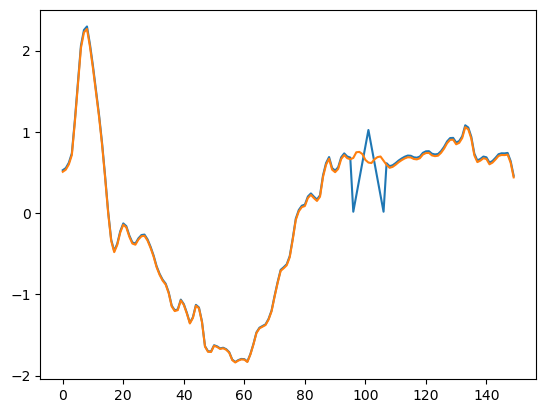

In [99]:
plt.plot(pdata['pdata_ws'][0].flatten(),label='with shapelet')
plt.plot(pdata['pdata_wos'][0].flatten(),label='without shapelet')

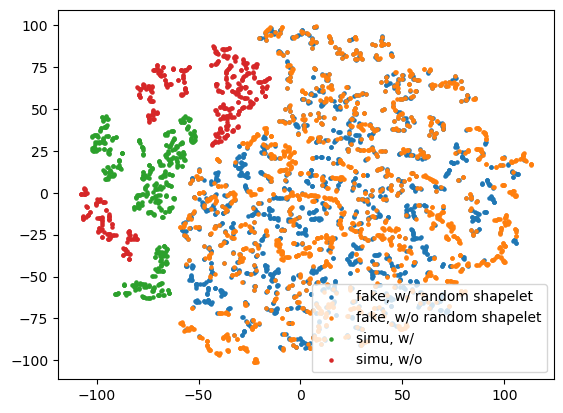

In [103]:
with open('probe/simu2/feature/probe_latent_label.pkl', 'rb') as f:
    probe_latent_label = pickle.load(f)
dataset_s_distances = probe_latent_label['dataset_s_distances']
pdata_s_distances = probe_latent_label['pdata_s_distances']
# best_threshold = probe_latent_label['best_threshold']
dataset_s_label = probe_latent_label['dataset_s_label']
pdata_s_label = probe_latent_label['pdata_s_label']
dataset_latent = probe_latent_label['dataset_latent']
pdata_latent = probe_latent_label['pdata_latent']
label = np.zeros(len(pdata_s_label)+len(dataset_s_label),dtype=np.uint8)
for i in range(len(pdata_s_label)+len(dataset_s_label)):
    if i<3360 and pdata_s_label[i]==0:
        label[i] = 0
    elif i<3360 and pdata_s_label[i]==1:
        label[i] = 1 
    elif i>=3360 and dataset_s_label[i-3360]==0:
        label[i] = 2
    elif i>=3360 and dataset_s_label[i-3360]==1:
        label[i] = 3

from sklearn.manifold import TSNE
tsne = TSNE(perplexity=5)
latent_vis = tsne.fit_transform(np.concatenate((pdata_latent,dataset_latent)))
plt.scatter(latent_vis[label == 0, 0], latent_vis[label == 0, 1], label='fake, w/ random shapelet', s=5)
plt.scatter(latent_vis[label == 1, 0], latent_vis[label == 1, 1], label='fake, w/o random shapelet', s=5)
plt.scatter(latent_vis[label == 2, 0], latent_vis[label == 2, 1], label='simu, w/', s=5, color=plt.get_cmap('tab10')(2))
plt.scatter(latent_vis[label == 3, 0], latent_vis[label == 3, 1], label='simu, w/o', s=5, color=plt.get_cmap('tab10')(3))

plt.legend()
plt.savefig('probe/simu2/feature/tsne.png')

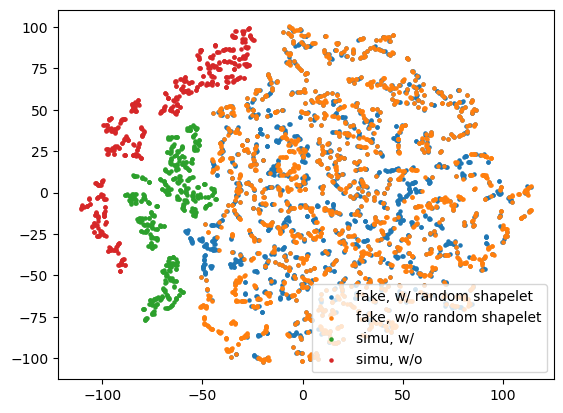

In [105]:
with open('probe/simu2/seen_nonfeature/probe_latent_label.pkl', 'rb') as f:
    probe_latent_label = pickle.load(f)
dataset_s_distances = probe_latent_label['dataset_s_distances']
pdata_s_distances = probe_latent_label['pdata_s_distances']
# best_threshold = probe_latent_label['best_threshold']
dataset_s_label = probe_latent_label['dataset_s_label']
pdata_s_label = probe_latent_label['pdata_s_label']
dataset_latent = probe_latent_label['dataset_latent']
pdata_latent = probe_latent_label['pdata_latent']
label = np.zeros(len(pdata_s_label)+len(dataset_s_label),dtype=np.uint8)
for i in range(len(pdata_s_label)+len(dataset_s_label)):
    if i<3360 and pdata_s_label[i]==0:
        label[i] = 0
    elif i<3360 and pdata_s_label[i]==1:
        label[i] = 1 
    elif i>=3360 and dataset_s_label[i-3360]==0:
        label[i] = 2
    elif i>=3360 and dataset_s_label[i-3360]==1:
        label[i] = 3

from sklearn.manifold import TSNE
tsne = TSNE(perplexity=5)
latent_vis = tsne.fit_transform(np.concatenate((pdata_latent,dataset_latent)))
plt.scatter(latent_vis[label == 0, 0], latent_vis[label == 0, 1], label='fake, w/ random shapelet', s=5)
plt.scatter(latent_vis[label == 1, 0], latent_vis[label == 1, 1], label='fake, w/o random shapelet', s=5)
plt.scatter(latent_vis[label == 2, 0], latent_vis[label == 2, 1], label='simu, w/', s=5, color=plt.get_cmap('tab10')(2))
plt.scatter(latent_vis[label == 3, 0], latent_vis[label == 3, 1], label='simu, w/o', s=5, color=plt.get_cmap('tab10')(3))

plt.legend()
plt.savefig('probe/simu2/seen_nonfeature/tsne.png')

In [89]:
pdata = get_pdata(shapelet=seen_feature, selected_datasets=utils.selected_uni, inst_length=instance_length, 
                   num_shapelet=1, is_add=False, repeat_max=100,
                       is_z_norm=True, save_dir='probe/simu5/feature')
pdata = np.concatenate((pdata['pdata_ws'],pdata['pdata_wos']), axis=0)
dataset_s_label = np.array([0]*200+[1]*200)
p_data_labels = np.array([0]*1680 +[1]*1680)
shapelet_labels = [dataset_s_label,p_data_labels]

results = probe_shapelet(dataset=train_x, labels=train_y, pdata=pdata, model=model, save_path='probe/simu2/feature',
                         shapelet=seen_feature, pos=start_pos, device='cuda:1',shapelet_labels=shapelet_labels)

dealing with ECG200: (100, 1, 96)
dealing with Beef: (30, 1, 470)
dealing with ElectricDevices: (8926, 1, 96)
dealing with Earthquakes: (322, 1, 512)
dealing with Wafer: (1000, 1, 152)
dealing with PowerCons: (180, 1, 144)
dealing with NonInvasiveFetalECGThorax1: (1800, 1, 750)
dealing with ECG5000: (500, 1, 140)
dealing with HandOutlines: (1000, 1, 2709)
dealing with CBF: (30, 1, 128)
dealing with FordA: (3601, 1, 500)
dealing with TwoPatterns: (1000, 1, 128)
dealing with UWaveGestureLibraryAll: (896, 1, 945)
dealing with Chinatown: (20, 1, 24)
dealing with Yoga: (300, 1, 426)
dealing with DistalPhalanxOutlineCorrect: (600, 1, 80)
dealing with Computers: (250, 1, 720)
dealing with ShapesAll: (600, 1, 512)
dealing with Strawberry: (613, 1, 235)
(1000, 128) (3360, 128)
Training Accuracy = 0.75
Testing Accuracy = 0.74
----------------------
Accuracy = 0.50


In [91]:
pdata = get_pdata(shapelet=seen_nonfeature, selected_datasets=utils.selected_uni, inst_length=instance_length, 
                   num_shapelet=1, is_add=False, repeat_max=100,
                       is_z_norm=True, save_dir='probe/simu2/seen_nonfeature')
pdata = np.concatenate((pdata['pdata_ws'],pdata['pdata_wos']), axis=0)
dataset_s_label = np.array([0]*500+[1]*500)
p_data_labels = np.array([0]*1680 +[1]*1680)
shapelet_labels = [dataset_s_label,p_data_labels]

results = probe_shapelet(dataset=train_x, labels=train_y, pdata=pdata, model=model, save_path='probe/simu2/seen_nonfeature',
                         shapelet=seen_nonfeature, pos=start_pos, device='cuda:1',shapelet_labels=shapelet_labels)

dealing with ECG200: (100, 1, 96)
dealing with Beef: (30, 1, 470)
dealing with ElectricDevices: (8926, 1, 96)
dealing with Earthquakes: (322, 1, 512)
dealing with Wafer: (1000, 1, 152)
dealing with PowerCons: (180, 1, 144)
dealing with NonInvasiveFetalECGThorax1: (1800, 1, 750)
dealing with ECG5000: (500, 1, 140)
dealing with HandOutlines: (1000, 1, 2709)
dealing with CBF: (30, 1, 128)
dealing with FordA: (3601, 1, 500)
dealing with TwoPatterns: (1000, 1, 128)
dealing with UWaveGestureLibraryAll: (896, 1, 945)
dealing with Chinatown: (20, 1, 24)
dealing with Yoga: (300, 1, 426)
dealing with DistalPhalanxOutlineCorrect: (600, 1, 80)
dealing with Computers: (250, 1, 720)
dealing with ShapesAll: (600, 1, 512)
dealing with Strawberry: (613, 1, 235)
(1000, 128) (3360, 128)
Training Accuracy = 0.65
Testing Accuracy = 0.65
----------------------
Accuracy = 0.50


In [94]:
pdata = get_pdata(shapelet=unseen_nonfeature, selected_datasets=utils.selected_uni, inst_length=instance_length, 
                   num_shapelet=1, is_add=False, repeat_max=100,
                       is_z_norm=True, save_dir='probe/simu2/unseen_nonfeature')
pdata = np.concatenate((pdata['pdata_ws'],pdata['pdata_wos']), axis=0)
dataset_s_label = np.array([0]*500+[1]*500)
p_data_labels = np.array([0]*1680 +[1]*1680)
shapelet_labels = [dataset_s_label,p_data_labels]

results = probe_shapelet(dataset=train_x, labels=train_y, pdata=pdata, model=model, save_path='probe/simu2/unseen_nonfeature',
                         shapelet=seen_nonfeature, pos=start_pos, device='cuda:1',shapelet_labels=shapelet_labels)

dealing with ECG200: (100, 1, 96)
dealing with Beef: (30, 1, 470)
dealing with ElectricDevices: (8926, 1, 96)
dealing with Earthquakes: (322, 1, 512)
dealing with Wafer: (1000, 1, 152)
dealing with PowerCons: (180, 1, 144)
dealing with NonInvasiveFetalECGThorax1: (1800, 1, 750)
dealing with ECG5000: (500, 1, 140)
dealing with HandOutlines: (1000, 1, 2709)
dealing with CBF: (30, 1, 128)
dealing with FordA: (3601, 1, 500)
dealing with TwoPatterns: (1000, 1, 128)
dealing with UWaveGestureLibraryAll: (896, 1, 945)
dealing with Chinatown: (20, 1, 24)
dealing with Yoga: (300, 1, 426)
dealing with DistalPhalanxOutlineCorrect: (600, 1, 80)
dealing with Computers: (250, 1, 720)
dealing with ShapesAll: (600, 1, 512)
dealing with Strawberry: (613, 1, 235)
(1000, 128) (3360, 128)
Training Accuracy = 0.80
Testing Accuracy = 0.80
----------------------
Accuracy = 0.50


In [49]:
probe_coef = results['classifier'].coef_.flatten()

In [96]:
import torch
import torch.nn as nn

# Assuming `fcn_model` is your pretrained tsai FCN model
class FCNWithSoftmax(nn.Module):
    def __init__(self, fcn_model):
        super(FCNWithSoftmax, self).__init__()
        self.fcn_model = fcn_model
        self.softmax = nn.Softmax(dim=1)  # Apply softmax across the class dimension

    def forward(self, x):
        logits = self.fcn_model(x)  # Get the logits from the original model
        probabilities = self.softmax(logits)  # Apply softmax to get probabilities
        return probabilities

# Load your trained FCN model
# fcn_model = load_your_trained_fcn_model()

# Wrap the FCN model with the softmax layer
fcn_with_softmax = FCNWithSoftmax(model)

In [95]:
#get_gradient_from_layers(model, hook_block, data, target_class: Union[int, Container], device='cuda')
from utils.model_utils import get_gradient_from_layers
c0_grad = get_gradient_from_layers(fcn_with_softmax, fcn_with_softmax.fcn_model.gap.gap, train_x[995:1005],0)
c0_grad

NameError: name 'fcn_with_softmax' is not defined

In [55]:
scores = c0_grad @ probe_coef #/ np.linalg.norm(c0_grad, axis=1) / np.linalg.norm(probe_coef)

In [56]:
scores

array([0.10849676, 0.10849615, 0.10849655, 0.10849614, 0.10851807,
       0.10849655, 0.10849655, 0.10849655, 0.10849655, 0.10849654])

In [30]:
with open('probe/simu_implet_random_scaled/probe_latent_label.pkl', 'rb') as f:
    probe_latent_label = pickle.load(f)
dataset_s_distances = probe_latent_label['dataset_s_distances']
pdata_s_distances = probe_latent_label['pdata_s_distances']
# best_threshold = probe_latent_label['best_threshold']
dataset_s_label = probe_latent_label['dataset_s_label']
pdata_s_label = probe_latent_label['pdata_s_label']
dataset_latent = probe_latent_label['dataset_latent']
pdata_latent = probe_latent_label['pdata_latent']

In [31]:
print(np.count_nonzero([i==1 for i in dataset_s_label]))
print(np.count_nonzero([i==0 for i in dataset_s_label]))

2000
0


In [236]:
print(np.count_nonzero([i==1 for i in pdata_s_label]))
print(np.count_nonzero([i==0 for i in pdata_s_label]))

1680
1680


In [37]:
with open('probe/simu_implet_random_scaled/results.pkl', 'rb') as f:
    results = pickle.load(f)
# pdata_s_pred = results['pdata_s_pred']
dataset_s_pred = results['dataset_s_pred']
print(np.count_nonzero([i==1 for i in dataset_s_pred]))
print(np.count_nonzero([i==0 for i in dataset_s_pred]))
# print(np.count_nonzero([i==1 for i in pdata_s_pred]))
# print(np.count_nonzero([i==0 for i in pdata_s_pred]))

501
1499


In [34]:
len(dataset_s_label)

2000

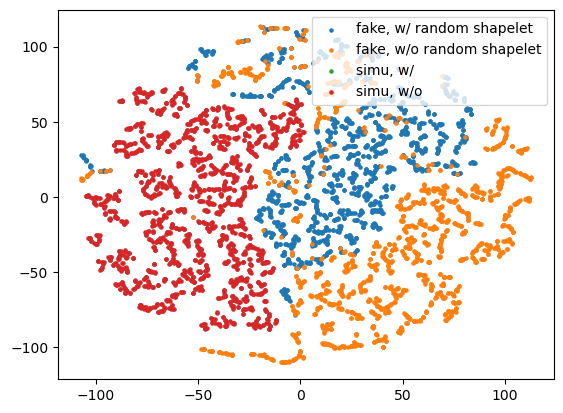

In [119]:
probe_shapelet(dataset=train_x, labels=train_y, pdata=test_x, model=model, 
                         shapelet=shapelet, pos=start_pos, device='cuda:1')

(2000, 128) (2000, 128)
Training Accuracy = 1.00
----------------------
Accuracy = 1.00
Precision = 1.00
Recall = 1.00
F1 Score = 1.00


{'pdata_s_pred': array([0., 0., 0., ..., 1., 1., 1.], dtype=float32),
 'dataset_s_pred': array([0., 0., 0., ..., 1., 1., 1.], dtype=float32),
 'accuracy': 0.998}